In [86]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
from cvxpy import *
from sklearn.utils import shuffle


style.use('ggplot')


class SVM():
    def __init__(self, data, kernel="linear", degree=1, g=100, k1=1, k2=1, C=50, method='ovo'):
        self.K = self.make_k(kernel, degree, g, k1, k2)
        self.kernel = kernel
        self.degree = degree
        self.g = g
        self.k1 = k1
        self.k2 = k2
        self.C = C
        self.method = method
        self.myfit, self.mypredict = self.make_environment()
        self.prepare_data(data)
        self.data = data.copy()
        self.normalized_data = normalize_df(data)
        self.maximum = np.array(self.data[self.data.columns.difference(['razred'])].max())
        self.minimum = np.array(self.data[self.data.columns.difference(['razred'])].min())
     
    def make_k(self, kernel, degree=1, g=100, k1=1, k2=1): 
        if kernel == 'linear':
            def jedro(x1, x2):
                return np.dot(x1, x2)
            return jedro
        elif kernel == 'polynomial':
            def jedro(x1, x2):
                return (1 + np.dot(x1, x2)) ** degree
            return jedro
        elif kernel == 'radial':
            def jedro(x1, x2):
                return np.exp(-g * np.linalg.norm(x1 - x2, axis=-1))
            return jedro
        elif kernel == 'neural':
            def jedro(x1, x2):
                return np.tanh(k1 * np.dot(x1, x2)+ k2) 
            return jedro

    
    def make_environment(self): 
        if self.method == 'ovo':
            def fit_one_versus_one(dataset=None):
                if dataset is None:
                    dataset = self.normalized_data
                napovedi = dict()
                for i in range(self.stevilo_razredov):
                    for j in range(i):
                        data = dataset.loc[dataset['razred'].isin([i, j])]
                        X = np.array(data.drop(['razred'], 1)).astype(np.float)
                        y = np.array(data['razred']).astype(np.float)
                        y[y == j] = -1
                        y[y == i] = 1
                        a, b, indeksi = self._fit(X, y)
                        napovedi[(i,j)] = (a, b, indeksi)
                return napovedi
            
            def predict_one_versus_one(X, napovedi, dataset=None):
                if dataset is None:
                    dataset = self.normalized_data
                glasovi = np.zeros(self.stevilo_razredov)
                for i in range(self.stevilo_razredov):
                    for j in range(i):
                        data = dataset.loc[dataset['razred'].isin([i, j])]
                        X_data = np.array(data.drop(['razred'], 1)).astype(np.float)
                        y_data = np.array(data['razred']).astype(np.float)
                        y_data[y_data == j] = -1
                        y_data[y_data == i] = 1
                        glas = self._predict(X, X_data, y_data, *napovedi[(i,j)])
                        if glas == 1:
                            glasovi[i] += 1
                        else:
                            glasovi[j] += 1
                return np.argmax(glasovi)
            return fit_one_versus_one, predict_one_versus_one
        
        elif self.method == 'ova':
            def fit_one_versus_all(dataset=None):
                if dataset is None:
                    dataset = self.normalized_data
                napovedi = dict()
                for i in range(self.stevilo_razredov):
                    X_train = np.array(dataset.drop(['razred'], 1)).astype(np.float)
                    y_train = np.array(dataset['razred']).astype(np.float)
                    y_train[y_train != i] = -1
                    y_train[y_train == i] = 1
                    napovedi[i] = self._fit(X_train, y_train)
                return napovedi
            def predict_one_versus_all(X, napovedi, dataset=None):
                if dataset is None:
                    dataset = self.normalized_data
                glasovi = np.zeros(self.stevilo_razredov)
                for i in range(self.stevilo_razredov):
                    X_data = np.array(dataset.drop(['razred'], 1)).astype(np.float)
                    y_data = np.array(dataset['razred']).astype(np.float)
                    y_data[y_data != i] = -1
                    y_data[y_data == i] = 1
                    glasovi[i] = self.classifier(X, X_data, y_data, *napovedi[i])
                return np.argmax(glasovi)
            return fit_one_versus_all, predict_one_versus_all
        else: 
            raise ValueError('No such method is known to this program. Try ovo (one versus one) or ova (one versus all)')
            
  
    def prepare_data(self, df):
        self.stevilo_razredov = df.razred.nunique()
        self.to_indeks = dict()
        self.to_name = dict()
        for indeks, name in enumerate(df.razred.unique()):
            self.to_indeks[name] = indeks
            self.to_name[indeks] = name
        df.replace(self.to_indeks, inplace=True)
                      
    
    def fit(self):
        self.napovedi = self.myfit()
        X = np.array(self.normalized_data.drop(['razred'], 1)).astype(np.float)
        y = np.array(self.normalized_data['razred']).astype(np.float)
        self.accuracy_on_set = self.test(X, y, self.napovedi, self.normalized_data)
   
    def cross_validate(self, k=10):
        self.split_data = split_data(self.data, k)
        results = []
        tests = []
        for i in range(k):
            test = self.split_data[i]
            train = pd.concat([df for num, df in enumerate(self.split_data) if not num == i])
            maximum = np.array(train[train.columns.difference(['razred'])].max())
            minimum = np.array(train[train.columns.difference(['razred'])].min())
            train = normalize_df(train)
            test_X = np.array(test.drop(['razred'], 1)).astype(np.float)
            test_y = np.array(test['razred']).astype(np.float)
            test_X = (test_X - minimum) / (maximum - minimum)
            napovedi = self.myfit(dataset=train)
            accuracy = self.test(test_X, test_y, napovedi, train)
            results.append((napovedi, accuracy))
            tests.append(accuracy)
        self.results = results
        self.accuracy_test = np.array(tests)
        self.accuracy = np.mean(self.accuracy_test)
           
    def test(self, X, y, napovedi, dataset):
        all_instances = 0
        correct_instances = 0
        for index, instance in enumerate(X):
            all_instances += 1
            if self.mypredict(instance, napovedi, dataset=dataset) == y[index]:
                correct_instances += 1
        accuracy = correct_instances/all_instances
        return accuracy
          
    def predict(self, X, df, ydf, a, b):
        X = (X - self.minimum) / (self.maximum - self.minimum)
        return self._predict(X, df, ydf, a, b)
    
    def _predict(self, X, df, ydf, a, b, indeksi):
        return np.sign(self.classifier(X, df, ydf, a, b, indeksi))
    
    
    def posplosen_skalarni_produkt(self, x_j, X, y, alpha, indeksi):
        rezultat = 0
        for i in indeksi: 
            rezultat += alpha[i] * y[i] * self.K(x_j, X[i])
        return rezultat
        
    
    def find_support_vectors(self, alpha,X, y, odpad= 10 ** (-5), odstopanje=0.99):
        a = np.amax(alpha)
        #poiščemo indkse, za katere so X[i] podporni vektorji
        indeksi = []
        for i in range(len(alpha)):
            if alpha[i]/a >= odpad:
                indeksi.append(i)
        #sedaj določimo b, ki ga potrebujemo za napoved.
        #B je vektor, ki ga bomo polnili z različnimi b-ji nato pa izračunalil njigevo povprečje
        B = []
        for i in indeksi:
            if alpha[i] < self.C * odstopanje:
                B.append(y[i] - self.posplosen_skalarni_produkt(X[i], X, y, alpha, indeksi))
        
        b = np.mean(B)
        return (b, indeksi)
         
        
    def classifier(self, X, Xdf, ydf, a, b, indeksi):
        result = self.posplosen_skalarni_produkt(X, Xdf, ydf, a, indeksi)
        return result + b
    

    
    def visualize(self, h=0.5):
        if len(self.data.columns) != 3:
            return 'Number of attribute dimensions is not 2'
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1,1,1)
        df = self.normalized_data
        
        #narišemo vse različne razrede kot scatter graf:
        seznam_razredov = df.razred.unique()
        x_stolpec, y_stolpec = df.columns.difference(['razred'])

        n = len(seznam_razredov)       
        color=iter(plt.cm.rainbow(np.linspace(0,1,n)))
        
        
        for razred in seznam_razredov:
            data = df.loc[df['razred'] == razred]
            c=next(color)
            self.ax.scatter(data[x_stolpec], data[y_stolpec], c=c)
        
        #for lines
        h = .05  # step size in the mesh
        # create a mesh to plot in
        x_min, x_max = -0.2, 1.2
        y_min, y_max = -0.2, 1.2
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        #narišemo vse meje med posameznimi razredi:
        if self.method == 'ovo':
            for i in range(self.stevilo_razredov):
                for j in range(i):
                    data = self.normalized_data.loc[self.normalized_data['razred'].isin([i, j])]
                    data = self.normalized_data.loc[self.normalized_data['razred'].isin([i, j])]
                    Xdf = np.array(data.drop(['razred'], 1)).astype(np.float)
                    ydf = np.array(data['razred']).astype(np.float)
                    ydf[ydf != i] = -1
                    ydf[ydf == i] = 1


                    # Plot the decision boundary. For that, we will assign a color to each
                    # point in the mesh [x_min, m_max]x[y_min, y_max].
                    Z = self.classifier(np.c_[xx.ravel(), yy.ravel()], Xdf, ydf, *self.napovedi[(i,j)])

                    # Put the result into a color plot
                    Z = Z.reshape(xx.shape)
                    plt.contour(xx, yy, Z, levels=[-1 , 0, 1], colors=('grey', 'black', 'grey'), linestyles=('dashed', 'solid', 'dashed'))
        
        
        if self.method == 'ova':
            for i in range(self.stevilo_razredov):
                Xdf = np.array(df.drop(['razred'], 1)).astype(np.float)
                ydf = np.array(df['razred']).astype(np.float)
                ydf[ydf != i] = -1
                ydf[ydf == i] = 1
                
                # Plot the decision boundary. For that, we will assign a color to each
                # point in the mesh [x_min, m_max]x[y_min, y_max].
                Z = self.classifier(np.c_[xx.ravel(), yy.ravel()], Xdf, ydf, *self.napovedi[i])

                # Put the result into a color plot
                Z = Z.reshape(xx.shape)
                plt.contour(xx, yy, Z, levels=[-1 , 0, 1], colors=('grey', 'black', 'grey'), linestyles=('dashed', 'solid', 'dashed'))


        
        #for coloring
        # create a mesh to plot in
        
        X = np.c_[xx.ravel(), yy.ravel()]
        Z = np.zeros(len(X))
        for index, i in enumerate(X):
            Z[index] = self.mypredict(i, self.napovedi)

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.1)
            
        plt.savefig('sample.pdf')
        plt.show()
        
    
        
    def _fit(self, X, y):
        n = len(X)
        m = len(X[0])
    
        a = Variable(n)

        # we have to generate matrix from X and y
        # we create matrix based on rigth kernel  
        A = np.zeros(shape=(n,n))
        for i in range(n):
            for j in range(n):
                A[i][j] = self.K(X[i], X[j])

        obj = Maximize(sum_entries(a) - 1/2 * quad_form(a, np.dot(np.dot(np.diag(y), A), np.diag(y))))

        constraints = [a >= 0,  a <= self.C, a.T * y == 0]
        
        prob = Problem(obj, constraints)
        prob.solve()

        a = np.squeeze(np.asarray(a.value))
        b, indeksi = self.find_support_vectors(a, X, y, odpad=10**(-5), odstopanje=0.99)
        
        return (a, b, indeksi)
        

        
def normalize_df(df):
    df[df.columns.difference(['razred'])] = df[df.columns.difference(['razred'])].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df    
    
def normalize_arr(X):
    X_normed = (X - X.min(0)) / X.ptp(0)
    return X_normed
    
def split_data(data, k=10):
    '''
    :param data:
    :param k:
    :return:
    '''
    data = shuffle(data)
    data.reset_index(drop=True,inplace=True)
    split_data = partition(data, k)
    return split_data
        
def partition(lst, n):
    '''
    :param lst: array of elemnts
    :param n: number of partitions
    :return: array partitioned into n arrays
    '''
    division = len(lst) / n
    return [lst[round(division * i):round(division * (i + 1))] for i in range(n)]


In [87]:
df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
df.columns = ['dolzina_casnega_lista', 'sirina_casnega_lista', 'dolzina_vencnega_lista', 'sirina_vencnega_lista', 'razred' ]
df = shuffle(df)
df.reset_index(drop=True,inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(['dolzina_vencnega_lista', 'sirina_vencnega_lista'], 1, inplace=True)
#df = df[df.razred != 'Iris-versicolor']
df[:10]

,dolzina_casnega_lista,sirina_casnega_lista,razred
0,6.9,3.1,Iris-versicolor
1,4.6,3.2,Iris-setosa
2,5.1,3.8,Iris-setosa
3,6.7,3.3,Iris-virginica
4,5.5,2.3,Iris-versicolor
5,7.9,3.8,Iris-virginica
6,5.7,2.8,Iris-versicolor
7,4.6,3.4,Iris-setosa
8,6.4,2.7,Iris-virginica
9,7.3,2.9,Iris-virginica


In [96]:
#df = df[df.razred != 'Iris-virginica']
#df.replace({'Iris-setosa': 1, 'Iris-versicolor': -1,}, inplace=True)
#df.drop(['dolzina_vencnega_lista', 'sirina_vencnega_lista'], 1, inplace=True)
#df.reset_index()
#df[:10]
clf = SVM(df, kernel='radial', degree= 11, g=10, C=10, method='ova')
clf.fit()

In [90]:
#clf.normalized_data[:10]
clf.napovedi

{0: (array([  9.99999999e+00,   2.48758262e-09,   9.58488750e-10,
           2.47659565e-08,   2.33190072e-08,   1.59007205e-10,
           3.47608158e-01,   1.42631471e-09,   9.99999996e+00,
           4.70667849e-08,   9.99999999e+00,   9.99999998e+00,
           4.77755627e-08,   7.72863310e-09,   5.57941371e-09,
           9.99999998e+00,   3.22799800e-09,   9.99999999e+00,
           9.99999998e+00,   9.99999999e+00,   5.25479400e+00,
           9.99999998e+00,   1.00000000e+01,   3.41790247e-10,
           1.59657579e-07,   1.68622064e-09,   9.58488750e-10,
           2.67601465e-09,   9.99999999e+00,   6.12640168e+00,
           9.99999999e+00,   7.04617803e-07,   9.99999999e+00,
           2.48157272e-09,   1.07313420e-07,  -4.05982212e-11,
           3.27239981e+00,   9.99999999e+00,   5.60968610e+00,
           5.81618841e-09,   1.21144280e-07,   9.99999987e+00,
           3.28896442e-09,   6.34350020e+00,   2.18627477e-09,
           4.09267400e-08,   9.58488750e-10,   9.999

In [98]:
clf.accuracy_on_set

0.9266666666666666

In [97]:
clf.cross_validate(k=10)

In [99]:
clf.accuracy


0.38666666666666666

In [100]:
clf.accuracy_test

array([ 0.2       ,  0.33333333,  0.4       ,  0.33333333,  0.46666667,
        0.33333333,  0.46666667,  0.46666667,  0.46666667,  0.4       ])

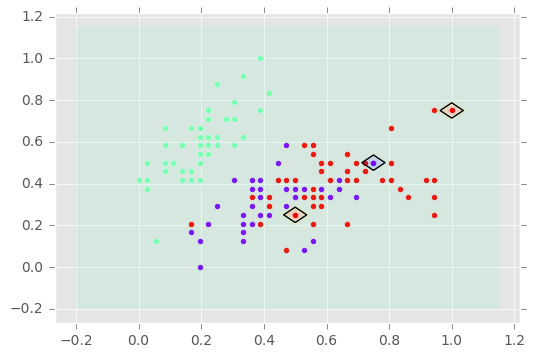

In [101]:
clf.visualize()

In [163]:
df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?', -99, inplace=True)
df.drop(['id'], 1, inplace=True)
df[['bare_nuclei']] = df[['bare_nuclei']].astype(float)
df.rename(columns={'class': 'razred'}, inplace=True)
df.loc[df['razred'] == 2, 'razred'] = 1
df.loc[df['razred'] == 4, 'razred'] = -1
df[:10]

,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bare_nuclei,bland_chrom,norm_nucleoli,mitoses,razred
0,5,1,1,1,2,1.0,3,1,1,1
1,5,4,4,5,7,10.0,3,2,1,1
2,3,1,1,1,2,2.0,3,1,1,1
3,6,8,8,1,3,4.0,3,7,1,1
4,4,1,1,3,2,1.0,3,1,1,1
5,8,10,10,8,7,10.0,9,7,1,-1
6,1,1,1,1,2,10.0,3,1,1,1
7,2,1,2,1,2,1.0,3,1,1,1
8,2,1,1,1,2,1.0,1,1,5,1
9,4,2,1,1,2,1.0,2,1,1,1


In [15]:
clf = SVM(df, kernel='linear')

In [16]:
clf.fit_one_versus_all(C=1)

In [31]:
clf.cross_validate()

In [32]:
clf.accuracy

0.65538302277432714

In [17]:
clf.predict_one_versus_all([5, 4, 4, 5, 7, 10, 3, 2, 1])

0

In [18]:
df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'razred' ]

df = df[df.razred != 'Iris-setosa']


df.replace({'Iris-versicolor': 1, 'Iris-virginica': -1,}, inplace=True)
df.reset_index()


df.drop(['petal_length', 'petal_width'], 1, inplace=True)


clf = SVM(df, kernel='polynomial', degree=1)
clf.fit_one_versus_all(C=1000)

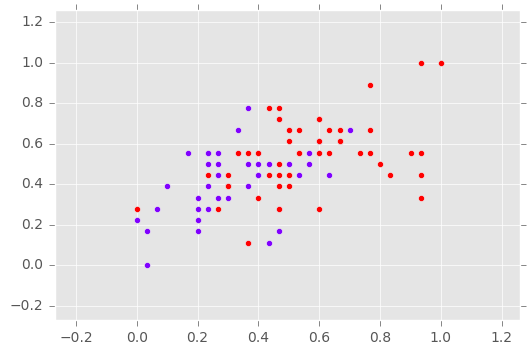

In [19]:
clf.visualize()

In [20]:
clf.cross_validate()
clf.accuracy

0.5

In [28]:
np.dot([1,2,3], [1,2,3])

14

In [75]:
df = pd.read_csv('ex8a.txt', sep=' |:', header=None, engine='python')
df.columns = ['razred', 'c', 'a', 'd', 'b']
df.drop(['c', 'd'], 1, inplace=True)

In [276]:
df[-5:]

,razred,a,b
858,1,0.994240,0.516667
859,1,0.964286,0.472807
860,1,0.975806,0.439474
861,1,0.989631,0.425439
862,1,0.996544,0.414912


In [76]:
clf = SVM(df, kernel='radial',g=100, C=10)

In [77]:
clf.fit()

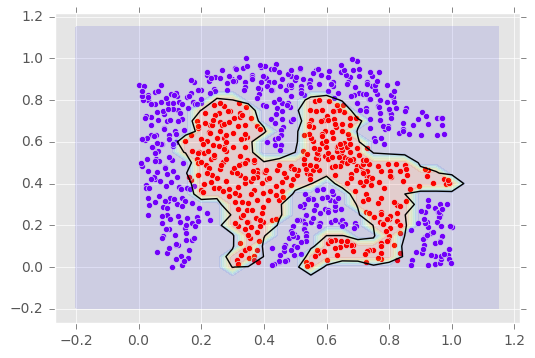

In [78]:
clf.visualize()

In [223]:
mu_vec1 = np.array([0,0])
cov_mat1 = np.array([[2,1],[1,1]])
x1_samples = np.random.multivariate_normal(mu_vec1, cov_mat1, 100)
mu_vec1 = mu_vec1.reshape(1,2).T # to 1-col vector

mu_vec2 = np.array([6,0])
cov_mat2 = np.array([[2,1],[1,1]])
x2_samples = np.random.multivariate_normal(mu_vec2, cov_mat2, 100)
mu_vec2 = mu_vec2.reshape(1,2).T

mu_vec3 = np.array([0,6])
cov_mat3 = np.array([[2,1],[1,1]])
x3_samples = np.random.multivariate_normal(mu_vec3, cov_mat3, 100)
mu_vec3 = mu_vec3.reshape(1,2).T

Y = np.array([0]*100 + [1]*100 + [2] * 100)
X = np.concatenate((x1_samples,x2_samples, x3_samples,), axis = 0) 
data = np.column_stack((X, Y,))
data = pd.DataFrame(data)
data.columns = ['x', 'y', 'razred']
clf = SVM(data, kernel='radial', g=1, C=100)
clf.fit()

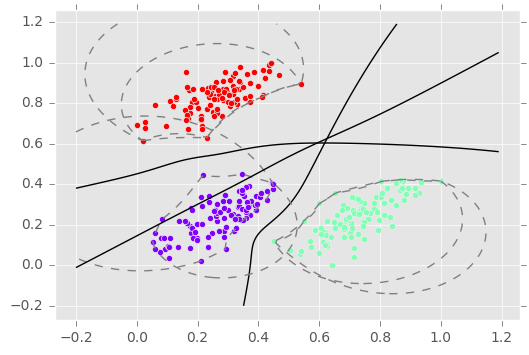

In [224]:
clf.visualize()

In [10]:
np.argmax([1,2,3, 2, 1])

2

In [159]:
10^2

8

In [177]:
10 ** (-5)

1e-05

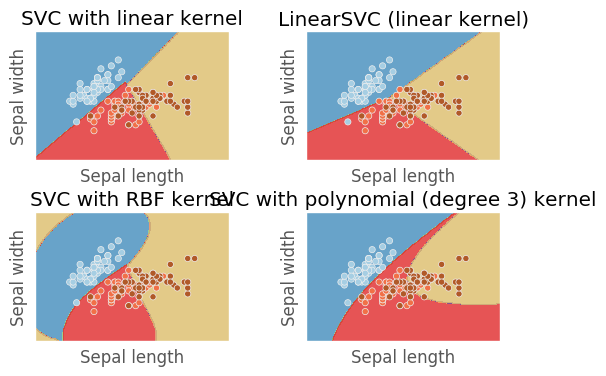

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()